This notebook is used to test the Ballpushing_utils.Fly.detect_boundaries() function that is used to generate start and end of corridors to compute relative ball and fly positions. It replicates the steps of the function but displays intermediate processing results to identify potential problems when automated processing fails.

In [1]:
import cv2
from scipy.ndimage import median_filter, gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

# Import a video and open the last frame

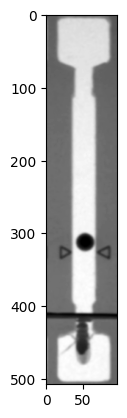

In [11]:
Video = "/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/240530_MagnetBlock_Videos_Tracked/arena7/corridor5/corridor5.mp4"

Video = "/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/240530_MagnetBlock_Videos_Tracked/arena2/corridor5/corridor5.mp4"
# open the video
cap = cv2.VideoCapture(str(Video))

# get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# set the current position to the last frame
cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)

# set the current position to the first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# read the last frame
ret, frame = cap.read()
cap.release()

if not ret:
    print(f"Error: Could not read frame from video {Video}")

elif frame is None:
    print(f"Error: Frame is None for video {Video}")


# Convert to grayscale
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Apply a median filter to smooth out noise and small variations
frame = median_filter(frame, size=3)

# Apply a Gaussian filter to smooth out noise and small variations
frame = gaussian_filter(frame, sigma=1)

# Display the frame using matplotlib
plt.imshow(frame, cmap="gray")
plt.show()

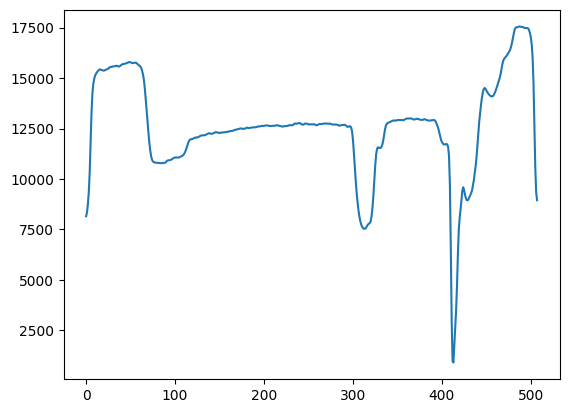

In [12]:
threshold = 100

# Compute the summed pixel values and apply a threshold
summed_pixel_values = frame.sum(axis=1)

# Plot the summed pixel values
plt.plot(summed_pixel_values)

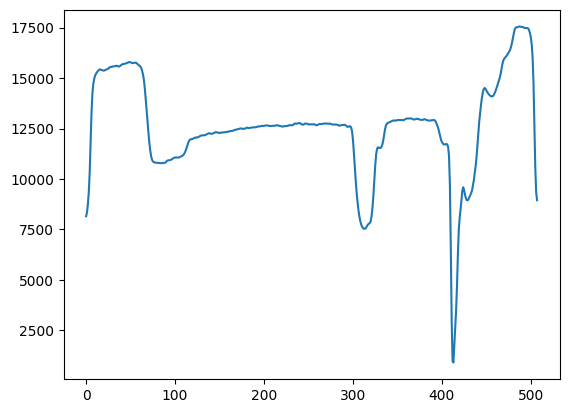

In [13]:
summed_pixel_values[summed_pixel_values < threshold] = 0

# Plot the summed pixel values after thresholding
plt.plot(summed_pixel_values)

Minimum row: 413


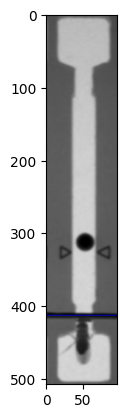

In [14]:
# Find the index of the minimum value in the thresholded summed pixel values
min_row = np.argmin(summed_pixel_values)

print(f"Minimum row: {min_row}")
# Display the frame with the minimum row highlighted
highlighted_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
highlighted_frame[min_row, :] = [0, 0, 255]

plt.imshow(highlighted_frame)
plt.show()

In [ ]:
def detect_boundaries(self, threshold=100):
    """Detects the start and end of the corridor in the video. This is later used to compute the relative distance of the fly from the start of the corridor.

    Args:
        threshold (int, optional): the pixel value threshold to used for the thresholding operation. Defaults to 100. Change value if boundaries are not correctly detected.

    Returns:
        frame (np.array): the last frame of the video.
        min_row (int): the index of the minimum value in the thresholded summed pixel values.
    """

    video_file = self.video

    if not video_file.exists():
        print(f"Error: Video file {video_file} does not exist")
        return None, None

    # open the video
    cap = cv2.VideoCapture(str(video_file))

    # get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # set the current position to the last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)

    # read the last frame
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Error: Could not read frame from video {video_file}")
        return None, None
    elif frame is None:
        print(f"Error: Frame is None for video {video_file}")
        return None, None

    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply a median filter to smooth out noise and small variations
    frame = median_filter(frame, size=3)

    # Apply a Gaussian filter to smooth out noise and small variations
    frame = gaussian_filter(frame, sigma=1)

    # Compute the summed pixel values and apply a threshold
    summed_pixel_values = frame.sum(axis=1)
    summed_pixel_values[summed_pixel_values < threshold] = 0

    # Check if the array is empty
    if summed_pixel_values.size == 0:
        print(
            f"Error: All pixel values in the last frame of video {video_file} are below the threshold"
        )
        return None, None

    # Find the index of the minimum value in the thresholded summed pixel values
    min_row = np.argmin(summed_pixel_values)

    # Save a .npy file with the start and end coordinates in the video folder
    np.save(video_file.parent / "coordinates.npy", [min_row - 30, min_row - 320])

    return frame, min_row

# New method

The previous method depended on locating the gates. If I have experiments without gates, it doesn't work. The new method will be based on detecting precisely the outer edges of the corridors and use these as landmarks

# Import a video and open the last frame

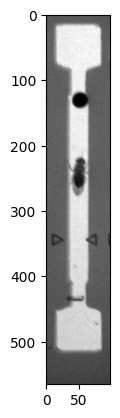

In [32]:
Video = "/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/240530_MagnetBlock_Videos_Tracked/arena7/corridor5/corridor5.mp4"

# open the video
cap = cv2.VideoCapture(str(Video))

# get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# set the current position to the last frame
cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)

# read the last frame
ret, frame = cap.read()
cap.release()

if not ret:
    print(f"Error: Could not read frame from video {Video}")

elif frame is None:
    print(f"Error: Frame is None for video {Video}")


# Convert to grayscale
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Display the frame using matplotlib
plt.imshow(frame, cmap="gray")
plt.show()

# Detect the edges of the arena

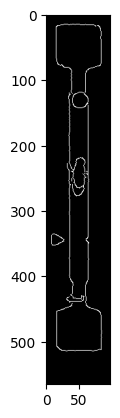

In [33]:
# Apply a Gaussian blur
frame = cv2.GaussianBlur(frame, (5, 5), 0)

# Use the Canny edge detection method
edges = cv2.Canny(frame, threshold1=30, threshold2=100)

# Display the edges
plt.imshow(edges, cmap="gray")
plt.show()

# Get the top and bottom edge y value

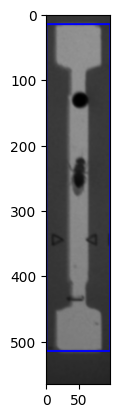

In [37]:
# Get the top and bottom edges of the corridor in y-direction
top_edge = np.min(np.where(edges > 0)[0])
bottom_edge = np.max(np.where(edges > 0)[0])

# Display the frame with the top and bottom edges highlighted
highlighted_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
highlighted_frame = cv2.rectangle(
    highlighted_frame, (0, top_edge), (frame.shape[1], bottom_edge), (0, 0, 255), 2
)

plt.imshow(highlighted_frame)
plt.show()

# Define the boundaries of the corridor based on the boundaries of the whole arena

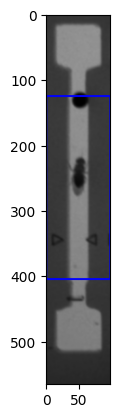

In [40]:
start = bottom_edge - 110

end = top_edge + 110

# Display the frame with the start and end of the corridor highlighted
highlighted_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
highlighted_frame = cv2.rectangle(
    highlighted_frame, (0, start), (frame.shape[1], end), (0, 0, 255), 2
)

plt.imshow(highlighted_frame)
plt.show()